#Team- Samuela, Nivetha, Pavithra, Haripriya

In [1]:
!pip install kaggle


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import os
from google.colab import files

uploaded = files.upload()


Saving kaggle.json to kaggle.json


In [3]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/


In [4]:
!chmod 600 ~/.kaggle/kaggle.json


In [5]:
!kaggle datasets download -d shawon10/ckplus


  0% 0.00/3.63M [00:00<?, ?B/s]
100% 3.63M/3.63M [00:00<00:00, 140MB/s]


In [6]:
!unzip ckplus.zip


Archive:  ckplus.zip
  inflating: CK+48/anger/S010_004_00000017.png  
  inflating: CK+48/anger/S010_004_00000018.png  
  inflating: CK+48/anger/S010_004_00000019.png  
  inflating: CK+48/anger/S011_004_00000019.png  
  inflating: CK+48/anger/S011_004_00000020.png  
  inflating: CK+48/anger/S011_004_00000021.png  
  inflating: CK+48/anger/S014_003_00000028.png  
  inflating: CK+48/anger/S014_003_00000029.png  
  inflating: CK+48/anger/S014_003_00000030.png  
  inflating: CK+48/anger/S022_005_00000030.png  
  inflating: CK+48/anger/S022_005_00000031.png  
  inflating: CK+48/anger/S022_005_00000032.png  
  inflating: CK+48/anger/S026_003_00000013.png  
  inflating: CK+48/anger/S026_003_00000014.png  
  inflating: CK+48/anger/S026_003_00000015.png  
  inflating: CK+48/anger/S028_001_00000022.png  
  inflating: CK+48/anger/S028_001_00000023.png  
  inflating: CK+48/anger/S028_001_00000024.png  
  inflating: CK+48/anger/S029_001_00000017.png  
  inflating: CK+48/anger/S029_001_00000018.png  

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

#path for image dataset folder
dpath = 'CK+48'

################PREPROCESSING##################
#map class labels to numeric labels
label_mapping = {'anger': 0,'contempt': 1,'disgust': 2,'fear': 3,'happy': 4,'sadness': 5,'surprise': 6}
images = []
labels = []

#iterate through subfolders anger,contempt, etc
for label in os.listdir(dpath):
    label_path = os.path.join(dpath, label) #gives folder path like CK+48/anger etc to access images

    #iterate through images in each subfolder
    for image_name in os.listdir(label_path):
        image_path = os.path.join(label_path, image_name) #gives image path

        #read image
        image = cv2.imread(image_path)

        #preprocess image
        image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #convert to grayscale, original image is grey color not in grayscale
        image = cv2.resize(image, (48, 48)) #resize to 48x48 pixels (gives more accuracy)
        image = image.astype('float32') / 255.0 #normalize data

        #add preprocessed image and its corresponding label to the lists
        images.append(image)
        labels.append(label_mapping[label]) #we map since we need numeric value to convert later in np array

#convert image and label lists to np arrays
images = np.array(images)
labels = np.array(labels)

print('Shape of images:', images.shape)
print('Shape of labels:', labels.shape)

Shape of images: (981, 48, 48)
Shape of labels: (981,)


In [8]:
############FEATURE EXTRACTION##############
from skimage.feature import hog
from skimage import data, exposure

#list to store extracted features
hog_features = []

#iterate through preprocessed images
for image in images:
    #extract HOG features
    #orientation determines the number of gradient orientations to consider
    #pixels per cell is size of each cell in pixels, & defines spatial extent over which gradients are computed
    #cells_per_blockis number of cells to be grouped together in each block & defines spatial extent over which histograms are normalized
    #multichannel is set true in case of color image
    hog_feature = hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), multichannel=False)

    #append HOG features to the list
    hog_features.append(hog_feature)

#converting list of features to np array
hog_features = np.array(hog_features)

#shape of the extracted features
print('Shape of extracted features:', hog_features.shape)

<ipython-input-8-b307ae66be97>:15: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  hog_feature = hog(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), multichannel=False)


Shape of extracted features: (981, 900)


In [56]:
###########SPLITTING, TRAINING AND ACCURACY#############
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score

#split the data into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(hog_features, labels, test_size=0.2, random_state=42)

#shapes of the training and testing sets
print('Shape of X_train:', X_train.shape)
print('Shape of y_train:', y_train.shape)
print('Shape of X_test:', X_test.shape)
print('Shape of y_test:', y_test.shape)

#KNN classifier
#put a wrong metric and in error it'll show list of valid metrics
#accuracy is highest when K=1
knn = KNeighborsClassifier(n_neighbors=1, metric='manhattan')
knn.fit(X_train, y_train)

#predict labels for the testing data
y_pred = knn.predict(X_test)

#accuracy
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy:', accuracy)

#cross-validation
scores = cross_val_score(knn, hog_features, labels, cv=5)

#cross-validation scores
print('Cross-validation scores:', scores)
print('Average score:', scores.mean())

#accuracy for each emotion
emotion_accuracy = {}
for emotion in label_mapping.keys():
    emotion_indices = np.where(y_test == label_mapping[emotion])[0]
    emotion_pred = y_pred[emotion_indices]
    emotion_true = y_test[emotion_indices]
    accuracy = accuracy_score(emotion_true, emotion_pred)
    emotion_accuracy[emotion] = accuracy

for emotion, accuracy in emotion_accuracy.items():
    print(f'Accuracy for {emotion}: {accuracy}')

Shape of X_train: (784, 900)
Shape of y_train: (784,)
Shape of X_test: (197, 900)
Shape of y_test: (197,)
Accuracy: 1.0
Cross-validation scores: [1.         0.95918367 0.93877551 0.98469388 0.9744898 ]
Average score: 0.9714285714285715
Accuracy for anger: 1.0
Accuracy for contempt: 1.0
Accuracy for disgust: 1.0
Accuracy for fear: 1.0
Accuracy for happy: 1.0
Accuracy for sadness: 1.0
Accuracy for surprise: 1.0


In [10]:
#accessing my drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<ipython-input-60-f070c085761b>:24: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  hog_feature = hog(preprocessed_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), multichannel=False)


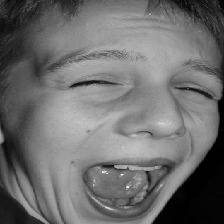

Predicted Emotion: surprise


<ipython-input-60-f070c085761b>:24: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  hog_feature = hog(preprocessed_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), multichannel=False)


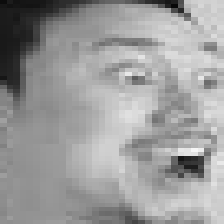

Predicted Emotion: happy


<ipython-input-60-f070c085761b>:24: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  hog_feature = hog(preprocessed_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), multichannel=False)


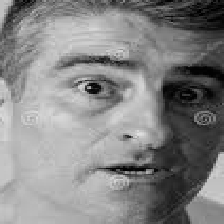

Predicted Emotion: disgust


<ipython-input-60-f070c085761b>:24: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  hog_feature = hog(preprocessed_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), multichannel=False)


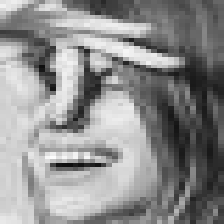

Predicted Emotion: fear


<ipython-input-60-f070c085761b>:24: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  hog_feature = hog(preprocessed_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), multichannel=False)


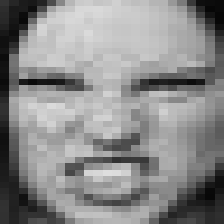

Predicted Emotion: happy


<ipython-input-60-f070c085761b>:24: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  hog_feature = hog(preprocessed_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), multichannel=False)


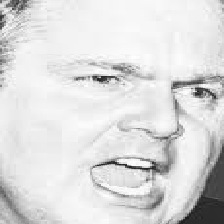

Predicted Emotion: sadness


<ipython-input-60-f070c085761b>:24: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  hog_feature = hog(preprocessed_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), multichannel=False)


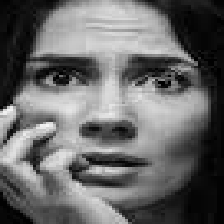

Predicted Emotion: fear


<ipython-input-60-f070c085761b>:24: FutureWarning: `multichannel` is a deprecated argument name for `hog`. It will be removed in version 1.0. Please use `channel_axis` instead.
  hog_feature = hog(preprocessed_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), multichannel=False)


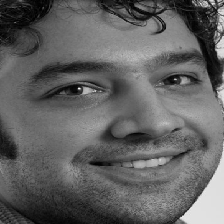

Predicted Emotion: happy


In [60]:
import random
from PIL import Image

#path to test folder
test_folder = '/content/drive/MyDrive/test'

#list all image files in test folder
image_files = [f for f in os.listdir(test_folder) if os.path.isfile(os.path.join(test_folder, f))]

#randomly select 8 images
random_images = random.sample(image_files, 8)

#preprocess and predict labels for the selected images
for image_file in random_images:
    image_path = os.path.join(test_folder, image_file)

    #read and preprocess the image
    image = cv2.imread(image_path)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (48, 48))
    preprocessed_image = resized.astype('float32') / 255.0

    #extract HOG features from preprocessed image
    hog_feature = hog(preprocessed_image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), multichannel=False)

    #reshape HOG features to match input shape of our model
    hog_feature = hog_feature.reshape(1, -1)

    #predict label for HOG features using trained model
    predicted_label = knn.predict(hog_feature)

    #map predicted label to corresponding emotion label
    predicted_emotion = [k for k, v in label_mapping.items() if v == predicted_label[0]][0]

    #show image and predicted label
    pil_image = Image.open(image_path)
    pil_image.show()
    print('Predicted Emotion:', predicted_emotion)

    #wait for a key press to move to the next image
    cv2.waitKey(0)

#close the OpenCV windows
cv2.destroyAllWindows()